In [1]:
import matplotlib.pyplot as plt
import math
import numpy as np
import ROOT, uproot
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn import feature_selection
from sklearn.model_selection import StratifiedKFold
import pandas as pd
from sklearn.utils import class_weight

# import necessary keras modules/functions
import keras
from keras.models import load_model
from keras.models import Sequential, Model
from keras.layers import Input, Flatten, Dense, Dropout, MaxPooling2D
from keras.layers import BatchNormalization, Activation, AveragePooling2D, Concatenate
from keras import regularizers
from keras.constraints import max_norm


from time import time

Welcome to JupyROOT 6.18/04


Using TensorFlow backend.
/home/bora/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/bora/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/bora/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/bora/.local/lib/python3.6/site-packages/tensorflow/python/framewo

In [2]:
df_signal = uproot.open("/mnt/harddisk4/scratch/signal_dtG1_delphes.root")["outtree"].pandas.df("*")
df_dyjets = uproot.open("/mnt/harddisk4/scratch/dyjets_flat.root")["outtree"].pandas.df("*")
df_wjets  = uproot.open("/mnt/harddisk4/scratch/wjets_flat.root")["outtree"].pandas.df("*")
n_events_to_be_used = min(len(df_dyjets),len(df_signal),len(df_wjets))
print(len(df_dyjets),len(df_signal),len(df_wjets))
n_events_to_be_used

1014 515858 1173


1014

In [3]:
df_signal.columns

Index(['br_weight', 'br_njets', 'br_nleptons', 'br_nbjets', 'br_scalar_HT',
       'br_jet_pt_1', 'br_jet_pt_2', 'br_jet_pt_3', 'br_jet_pt_4', 'br_MET',
       'br_MET_Phi', 'br_sphericity', 'br_aplanarity', 'br_Fox_Wolfram_1',
       'br_Fox_Wolfram_2', 'br_Fox_Wolfram_3', 'br_Fox_Wolfram_4'],
      dtype='object')

In [4]:
branches = ['br_njets', 'br_nleptons', 'br_nbjets', 'br_scalar_HT',
       'br_jet_pt_1', 'br_jet_pt_2', 'br_jet_pt_3', 'br_jet_pt_4', 'br_MET',
       'br_MET_Phi', 'br_sphericity', 'br_aplanarity', 'br_Fox_Wolfram_1',
       'br_Fox_Wolfram_2', 'br_Fox_Wolfram_3', 'br_Fox_Wolfram_4']

In [5]:
x_signal = df_signal.values
y_signal = np.full(len(x_signal) , 1)
x_dyjets = df_dyjets.values
x_wjets  = df_wjets.values
x_bkg    = np.concatenate((x_dyjets, x_wjets), axis=0)
y_bkg    = np.full(len(x_bkg) , 0)

In [6]:
x = np.concatenate((x_signal, x_bkg), axis=0)
y = np.concatenate((y_signal, y_bkg), axis=0)

In [7]:
x_train_unscaled, x_test_unscaled, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=20)
#y_train = keras.utils.to_categorical(y_train, 2)
#y_test  = keras.utils.to_categorical(y_test, 2)

In [8]:
scaler  = preprocessing.StandardScaler().fit(x)
x_train = scaler.transform(x_train_unscaled)
x_test  = scaler.transform(x_test_unscaled)

PLOT HISTOGRAMS

In [39]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('PaperStyle.mplstyle')
from matplotlib.ticker import ScalarFormatter,AutoMinorLocator, AutoLocator
import random

colourWheel =['#329932','#ff6961','b','#6a3d9a','#fb9a99','#e31a1c','#fdbf6f','#ff7f00','#cab2d6','#6a3d9a','#ffff99','#b15928','#67001f',
              '#b2182b','#d6604d','#f4a582','#fddbc7','#f7f7f7','#d1e5f0','#92c5de','#4393c3','#2166ac','#053061']

def plot_histo(ax, df, branch_name, sample_name, variable_name, color, alpha, binning_algo, ylog_scale=0):
    arr = df[branch_name].values
    #hist_y, bins, _ = ax.hist(arr, bins = binning_algo, alpha = alpha, color = color, edgecolor = 'black', linewidth = 0.0)
    counts, bin_edges = np.histogram(arr, bins = binning_algo)
    bin_centers = 0.5*(bin_edges[1:] + bin_edges[:-1])
    bin_err     = np.sqrt(counts)
    ax.errorbar(bin_centers, counts, yerr=bin_err, fmt='o-', color = color)
    if ylog_scale:
        ax.set_yscale("log")
    ax.legend((sample_name, ""), fontsize=24, framealpha=1., edgecolor="black")
    plt.tick_params(axis='both', which='major', labelsize=12)
    ax.set_xlabel(variable_name, fontsize=28)
    ax.set_ylabel("Number", fontsize=28)
    ax.set_ylim([1e-1, 1.2*max(counts)])

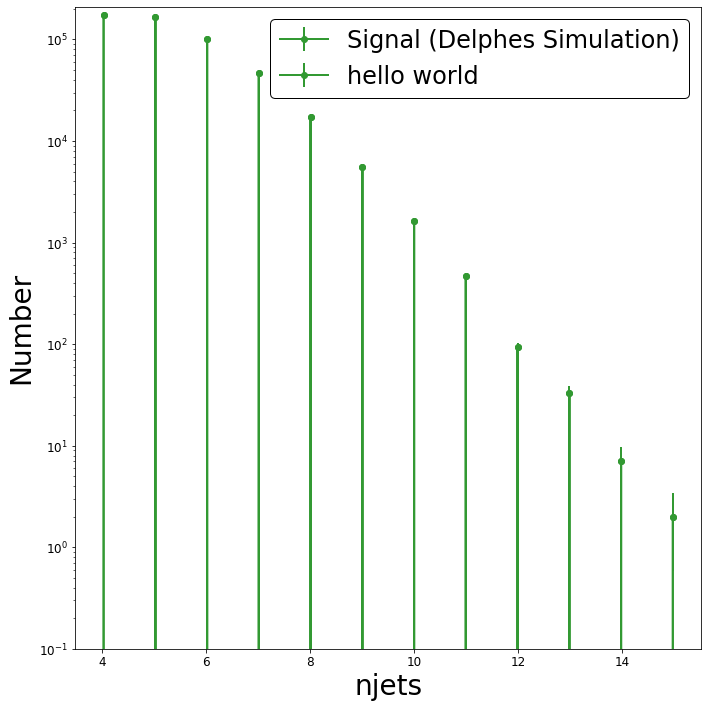

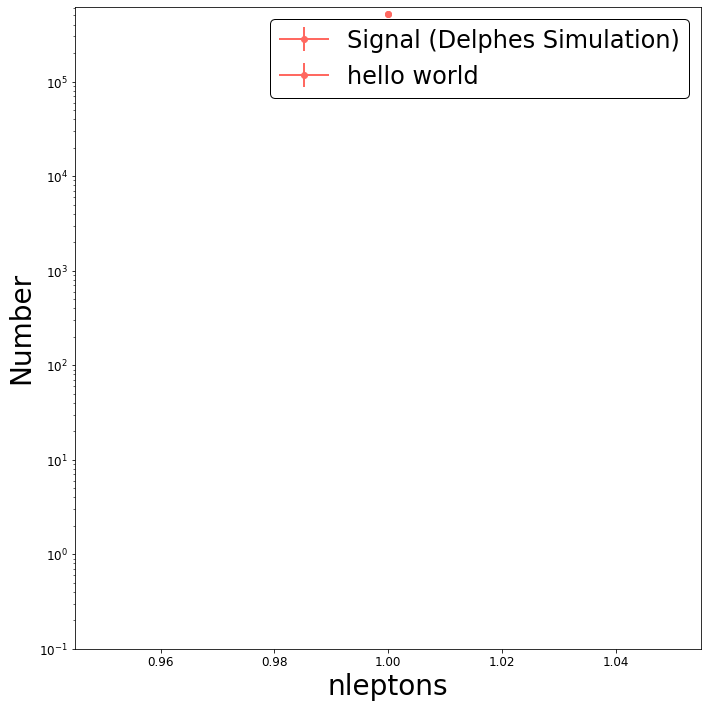

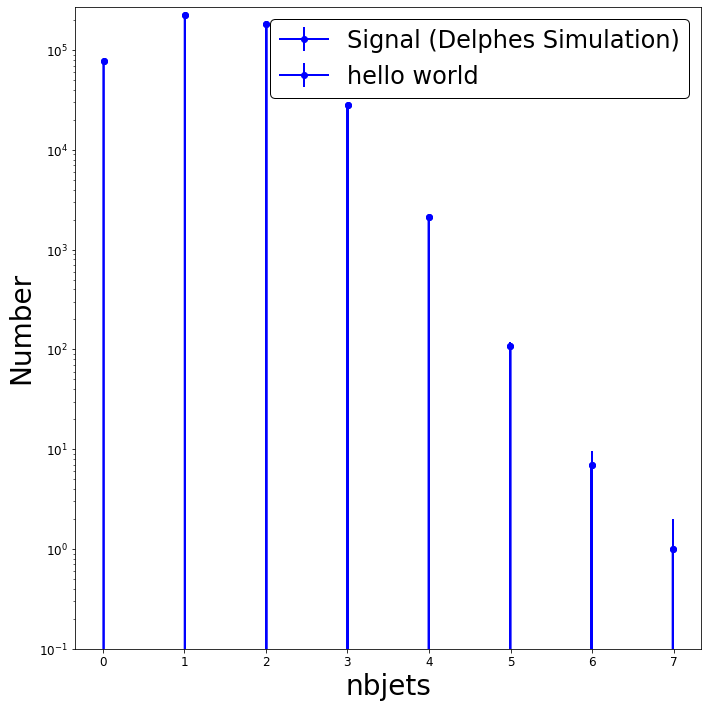

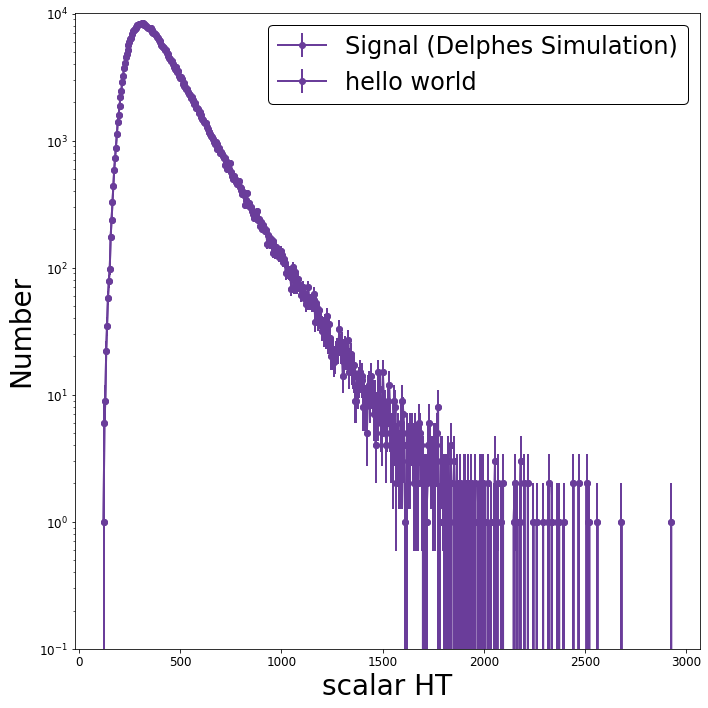

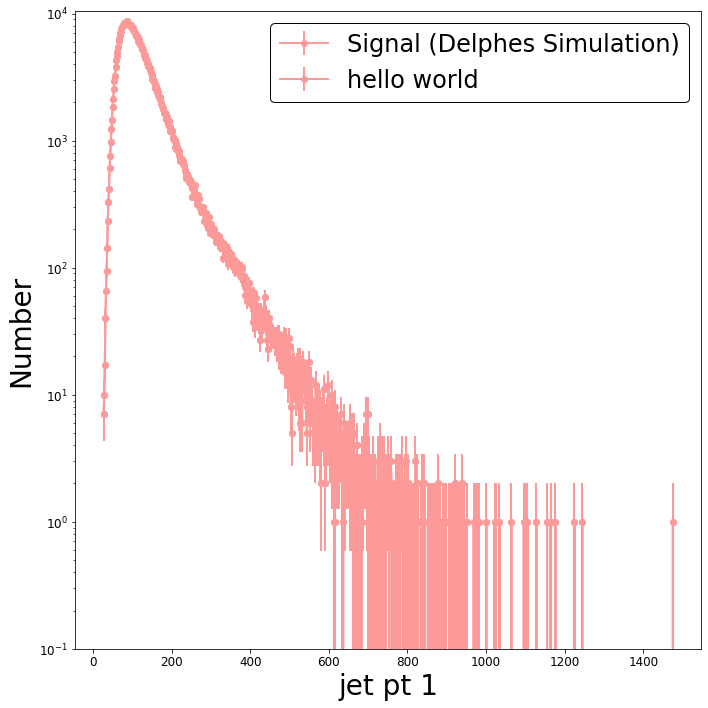

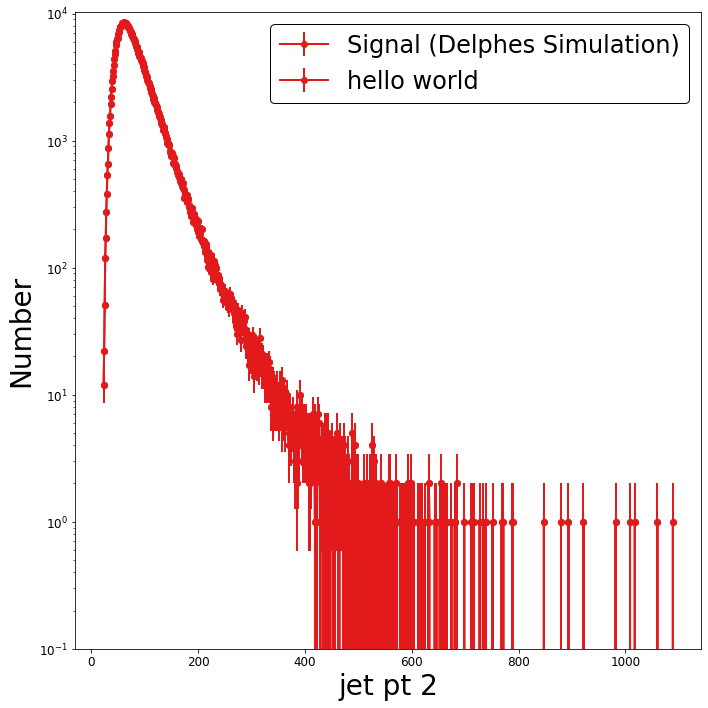

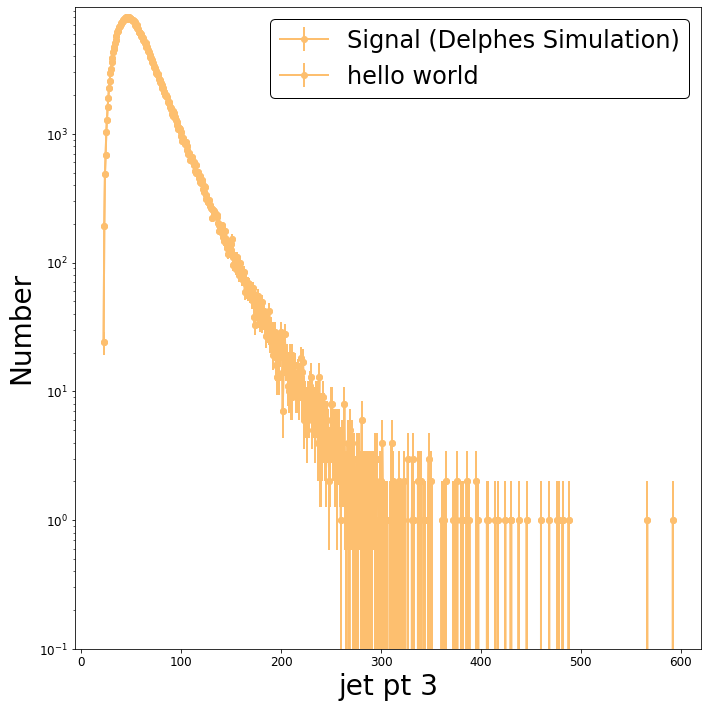

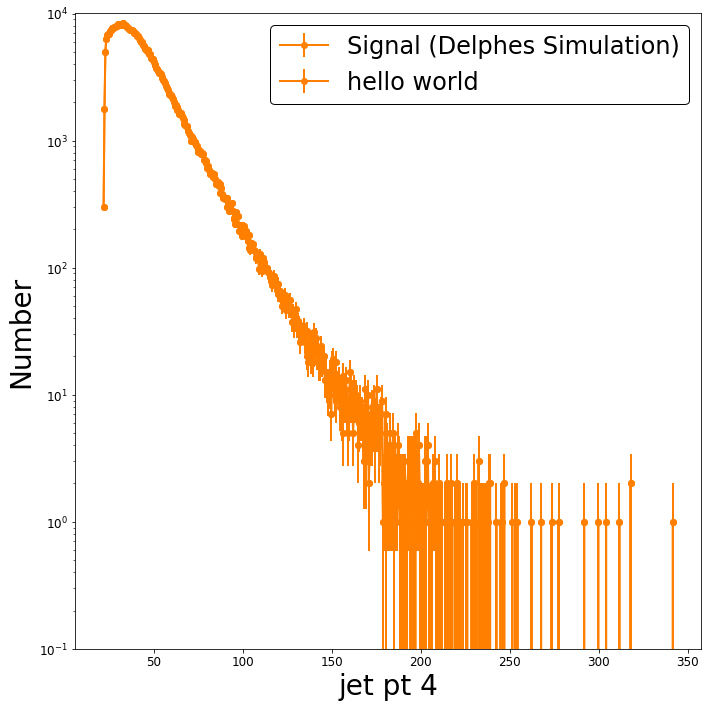

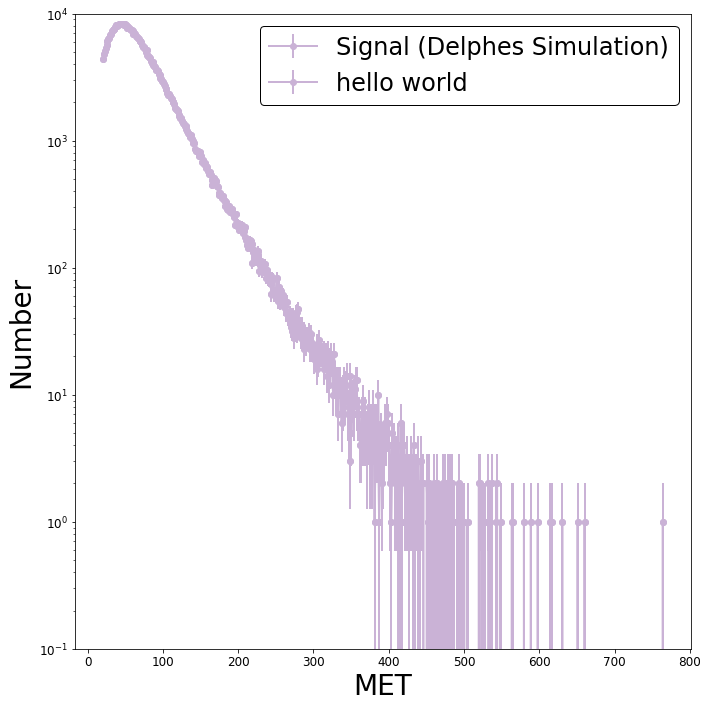

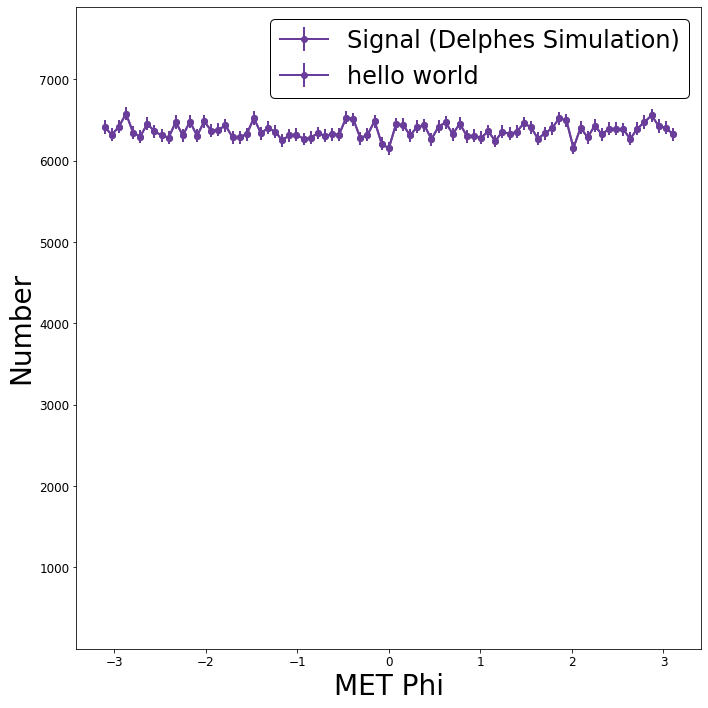

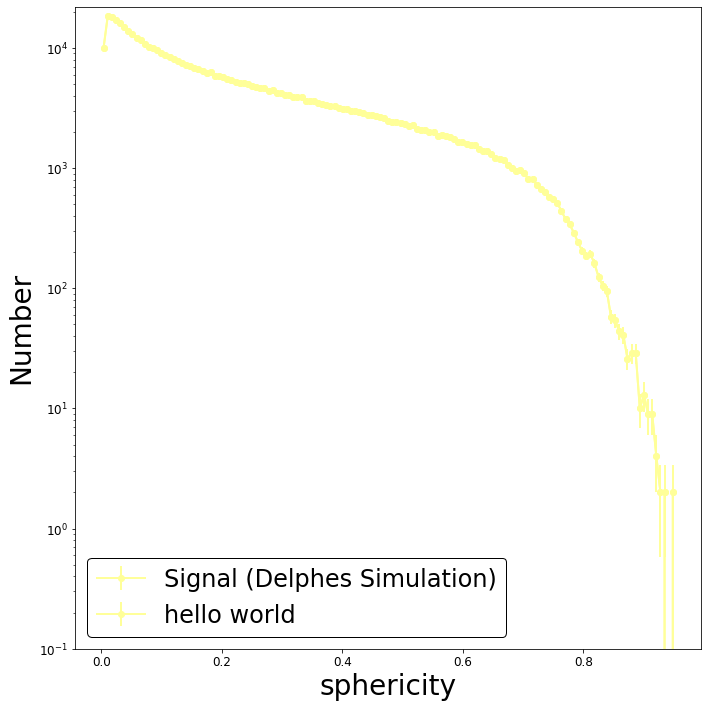

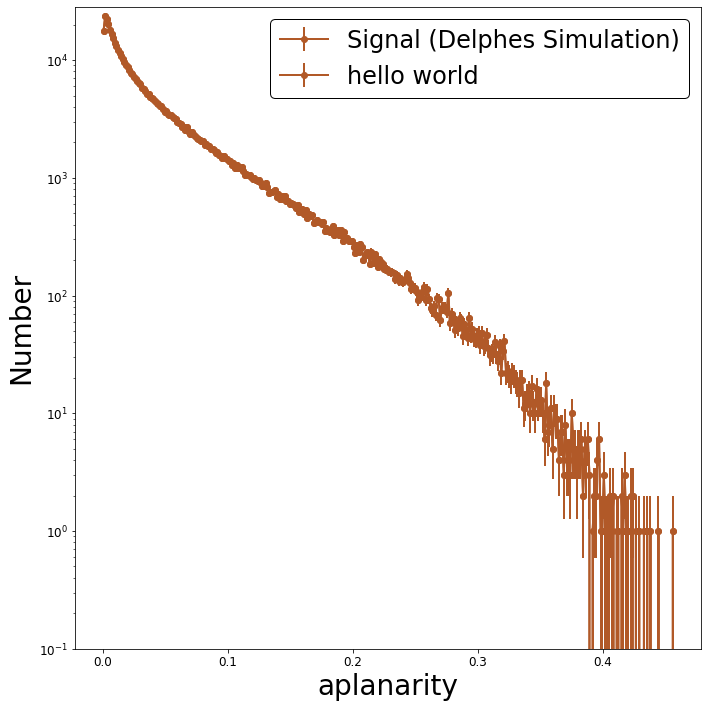

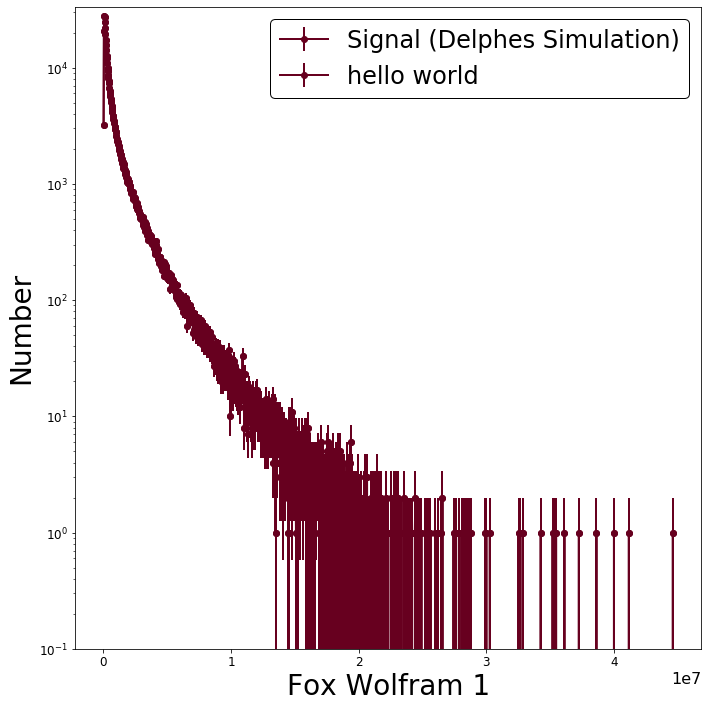

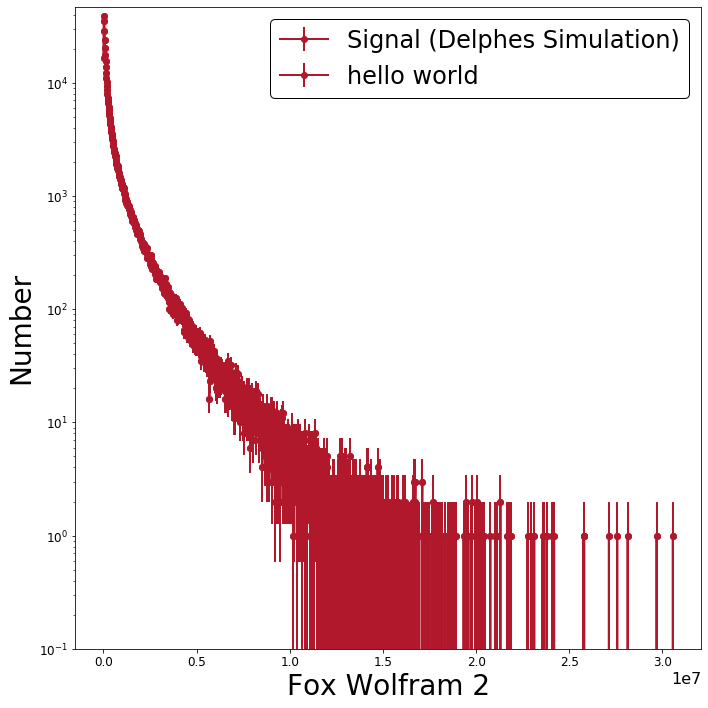

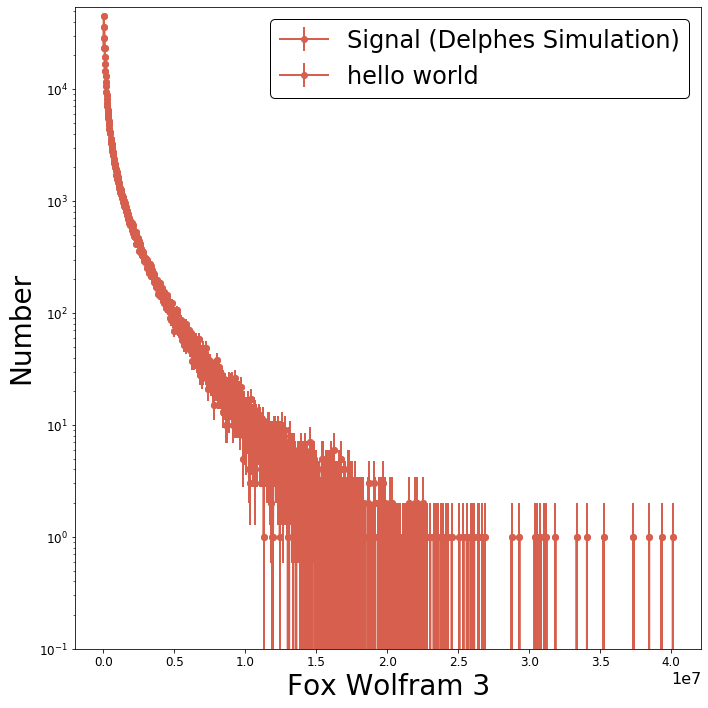

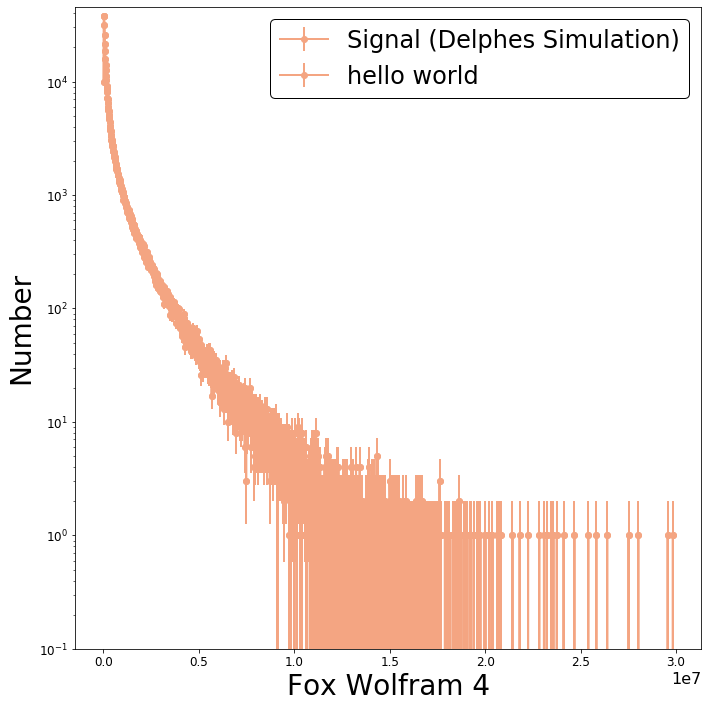

In [38]:
br_names_to_be_plotted = ['br_njets', 'br_nleptons', 'br_nbjets', 'br_scalar_HT',
       'br_jet_pt_1', 'br_jet_pt_2', 'br_jet_pt_3', 'br_jet_pt_4', 'br_MET',
       'br_MET_Phi', 'br_sphericity', 'br_aplanarity', 'br_Fox_Wolfram_1',
       'br_Fox_Wolfram_2', 'br_Fox_Wolfram_3', 'br_Fox_Wolfram_4']
use_log = [1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1]

sample_name = "Signal (Delphes Simulation)"

j=0
for i, branch_name in enumerate(br_names_to_be_plotted):
    fig, ax = plt.subplots()
    fig_size = 10
    fig.set_figheight(fig_size)
    fig.set_figwidth(fig_size)
    plot_histo(ax, df_signal, branch_name, sample_name, branch_name.replace("br_","").replace("_", " "),
               colourWheel[i], 0.99, "fd", use_log[i])
    plt.savefig("plots/pdf/"+sample_name.replace("(","").replace(")", "").replace(" ","_")+"_"+branch_name+".pdf", bbox_inches='tight')
    plt.savefig("plots/png/"+sample_name.replace("(","").replace(")", "").replace(" ","_")+"_"+branch_name+".png", bbox_inches='tight')

In [11]:
model = Sequential()
model.add(Dense(128, activation='relu'))
model.add(Dense(128, activation='sigmoid'))
model.add(Dense(1,   activation='sigmoid'))
model.compile(loss=keras.losses.mean_squared_error , optimizer=keras.optimizers.Adam(), metrics=['accuracy'])

In [ ]:
history = model.fit(x_train, y_train, epochs=20, batch_size=2**6,  verbose=1, validation_data=(x_test, y_test))

In [ ]:
model.summary()